In [191]:
EPS = 1e-10

In [192]:
"""
Node - базовый узел сетки
Хранит координаты, информацию о принадлежности к блокам и данные решения
"""
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Any
import numpy as np

from dataclasses import dataclass

@dataclass
class Frame:
    """Прямоугольная область в (s,t) пространстве"""
    s_min: float
    s_max: float
    t_min: float
    t_max: float
    @property
    def s_center(self) -> float:
        return (self.s_min + self.s_max) / 2
    
    @property
    def t_center(self) -> float:
        return (self.t_min + self.t_max) / 2
    
    def contains(self, s: float, t: float, eps: float = EPS) -> bool:
        """Проверяет, находится ли точка внутри фрейма"""
        return (self.s_min - eps <= s <= self.s_max + eps and
                self.t_min - eps <= t <= self.t_max + eps)

@dataclass
class Node:
    s: float  # пространственная координата
    t: float  # временная координата
    x: float = 0.0  # значение функции x
    y: float = 0.0  # значение функции y
    blocks: List[str] = field(default_factory=list)  # имена блоков, которым принадлежит узел
    data: Dict[str, Any] = field(default_factory=dict)  # дополнительные данные
    computed: bool = False  # <-- ИЗМЕНЕНИЕ: флаг вычисленности
    
    def add_block(self, block_name: str) -> None:
        if block_name not in self.blocks:
            self.blocks.append(block_name)
    
    def interpolate(self, other: 'Node', alpha: float) -> 'Node':
        """Линейная интерполяция между двумя узлами: alpha*self + (1-alpha)*other"""
        return Node(
            s=alpha*self.s + (1-alpha)*other.s,
            t=alpha*self.t + (1-alpha)*other.t,
            x=alpha*self.x + (1-alpha)*other.x,
            y=alpha*self.y + (1-alpha)*other.y,
            blocks=list(set(self.blocks + other.blocks))
        )
    def mark_computed(self) -> None:
        """Пометить узел как вычисленный"""
        self.computed = True

In [193]:
"""
Block - базовый класс для всех блоков
Определяет общий интерфейс для работы с узлами
"""
from abc import ABC, abstractmethod
from typing import List, Dict, Tuple, Optional, Any

class Block(ABC):
    def __init__(self, name: str):
        self.name = name
        self._nodes: Dict[Tuple[float, float], Node] = {}
    
    @property
    def nodes(self) -> List[Node]:
        """Возвращает все узлы блока в виде списка (унифицированный интерфейс)"""
        return list(self._nodes.values())
    
    def get_node(self, s: float, t: float) -> Optional[Node]:
        """Получить узел по координатам"""
        return self._nodes.get((s, t))
    
    def add_node(self, node: Node) -> None:
        """Добавить узел в блок"""
        key = (round(node.s, 10), round(node.t, 10))
        if key not in self._nodes:
            self._nodes[key] = node
        node.add_block(self.name)
    
    def clear_nodes(self) -> None:
        """Очистить все узлы блока"""
        self._nodes.clear()
    
    @abstractmethod
    def build(self, *args, **kwargs) -> None:
        """Абстрактный метод построения блока"""
        pass

In [194]:
"""
Characteristic - характеристика в HypBlock
Представляет собой линию в (s,t) пространстве, вдоль которой распространяется информация
Характеристики бывают положительные (c1) и отрицательные (c2)
"""
from typing import Dict, List, Tuple, Optional
import numpy as np

class Characteristic:
    def __init__(self, 
                 s_start: float, 
                 t_start: float, 
                 c: float, 
                 direction: str,
                 num: int,
                 char_type: str):
        """
        s_start, t_start - начальная точка характеристики
        c - коэффициент скорости (положительный)
        direction - 'positive' (ds/dt = +c) или 'negative' (ds/dt = -c)
        num - номер характеристики (i для negative, j для positive)
        char_type - 'x' для x-характеристик, 'y' для y-характеристик
        """
        self.s_start = s_start
        self.t_start = t_start
        self.c = c
        self.direction = direction
        self.num = num 
        self.char_type = char_type
        self.nodes: Dict[int, Node] = {}  # k: index -> Node
        
        # Уравнение характеристики: s = s_start + sign * c * (t - t_start)
        self.sign = 1.0 if direction == 'positive' else -1.0
    
    def get_point_at_t(self, t: float) -> Tuple[float, float]:
        """Получить точку на характеристике в момент времени t"""
        s = self.s_start + self.sign * self.c * (t - self.t_start)
        return s, t
    
    def add_node(self, index: int, node: Node) -> None:
        """Добавить узел на характеристике по индексу"""
        self.nodes[index] = node
    
    def get_node(self, index: int) -> Optional[Node]:
        """Получить узел по индексу"""
        return self.nodes.get(index)
    
    def is_boundary(self, index: int, s_range: Tuple[float, float]) -> bool:
        """Проверить, является ли узел граничным по пространству"""
        node = self.get_node(index)
        if not node:
            return False
        return abs(node.s - s_range[0]) < EPS or abs(node.s - s_range[1]) < EPS

    def set_nodes(self, center_node: Node, frame: Frame, dt: float) -> Dict[int, Node]:
        """
        Строит все узлы на характеристике внутри фрейма
        center_node - центральный узел характеристики (i=0 или j=0)
        frame - область
        dt - шаг по времени для этого семейства характеристик
        Возвращает словарь узлов {индекс: узел}
        """
        nodes = {0: center_node}
        
        # Движение вперед по времени (положительные индексы)
        k = 1
        t_current = center_node.t + dt
        while t_current <= frame.t_max + EPS:
            s = self.get_s_at_t(t_current)
            if frame.s_min - EPS <= s <= frame.s_max + EPS:
                node = Node(s=s, t=t_current)
                nodes[k] = node
                k += 1
                t_current += dt
            else:
                break
        
        # Движение назад по времени (отрицательные индексы)
        k = -1
        t_current = center_node.t - dt
        while t_current >= frame.t_min - EPS:
            s = self.get_s_at_t(t_current)
            if frame.s_min - EPS <= s <= frame.s_max + EPS:
                node = Node(s=s, t=t_current)
                nodes[k] = node
                k -= 1
                t_current -= dt
            else:
                break
        
        self.nodes = nodes
        return nodes
    
    def get_s_at_t(self, t: float) -> float:
        """Получить координату s в момент времени t на характеристике"""
        return self.s_start + self.sign * self.c * (t - self.t_start)
    
    def get_boundary_points(self, frame: Frame) -> Tuple[Optional[Node], Optional[Node]]:
        """Получить точки пересечения характеристики с границами фрейма"""
        # Начальная точка (при минимальном t)
        t_start = max(frame.t_min, self.t_start)
        s_start = self.get_s_at_t(t_start)
        start_node = None
        if frame.s_min <= s_start <= frame.s_max:
            start_node = Node(s=s_start, t=t_start)
        
        # Конечная точка (при максимальном t)
        t_end = min(frame.t_max, self.t_start + (frame.s_max - self.s_start) / (self.sign * self.c))
        s_end = self.get_s_at_t(t_end)
        end_node = None
        if frame.s_min <= s_end <= frame.s_max:
            end_node = Node(s=s_end, t=t_end)
        
        return start_node, end_node

In [366]:
"""
HypBlock - блок характеристической сетки для гиперболических систем
Строит сетку вдоль характеристик уравнения:
    dx/dt - c1*dx/ds = ...  (положительная характеристика)
    dy/dt + c2*dy/ds = ...  (отрицательная характеристика)
Сетка строится либо с постоянным шагом по времени h, либо равномерно по S
"""
from typing import Dict, List, Tuple, Optional, Set
import numpy as np
import math 

class HypBlock(Block):
    def __init__(self, name: str, c1: float, c2: float, frame: Frame):
        super().__init__(name)
        self.c1 = c1  # скорость для положительных характеристик
        self.c2 = c2  # скорость для отрицательных характеристик
        self.frame = frame
        self.x_chars: Dict[int, Characteristic] = {}
        self.y_chars: Dict[int, Characteristic] = {}
        
        
    def build(self, h: float) -> None:
        """
        Построение сетки с постоянным шагом по времени h,
        характеристики с индексами i=0 и j=0 проходят через центр области
        """
        self.clear_nodes()
        
        s0, s1 = self.frame.s_min, self.frame.s_max
        t0, t1 = self.frame.t_min, self.frame.t_max
        
        # Вычисляем шаги
        ds = h * self.c1 * self.c2 / (self.c1 + self.c2)
        dt1 = ds / self.c1  # шаг по времени для x-характеристик
        dt2 = ds / self.c2  # шаг по времени для y-характеристик
        
        # Центральная точка
        s_center = (s0 + s1) / 2
        t_center = (t0 + t1) / 2

        print(-self.c1, s1, t1, s_center, t_center)
        print(self.c2, s0, t1, s_center, t_center)
        # Вычисляем предельные индексы для x-характеристик (отрицательных)
        i_max = self._get_count_char(-self.c1, s1, t1, s_center, t_center, dt2)
        print(i_max)
        # Строим x-характеристики (отрицательные)
        for i in range(-i_max, i_max + 1):
            s = s_center + i * ds
            t = t_center + i * dt1
            if s0 - EPS <= s <= s1 + EPS:
                # Создаем характеристику через центр
                x_char = Characteristic(s, t, self.c2, 'negative', i, 'x')
                
                # Создаем центральный узел
                center_node = Node(s=s, t=t)
                
                # Настраиваем все узлы на характеристике
                x_char.set_nodes(center_node, self.frame, dt2)
                
                # Добавляем характеристику
                self.x_chars[i] = x_char
                
                # Добавляем все узлы характеристики в блок
                for node in x_char.nodes.values():
                    self.add_node(node)
        
        # Вычисляем предельные индексы для y-характеристик (положительных)
        j_max = self._get_count_char(self.c2, s0, t1, s_center, t_center, dt1)
        print(j_max)
        # Строим y-характеристики (положительные)
        for j in range(-j_max, j_max + 1):
            s = s_center + j * ds
            t = t_center - j * dt2
            if s0 - EPS <= s <= s1 + EPS:
                # Создаем характеристику через центр
                y_char = Characteristic(s, t, self.c1, 'positive', j, 'y')
                
                # Создаем центральный узел
                center_node = Node(s=s, t=t)
                
                # Настраиваем все узлы на характеристике
                y_char.set_nodes(center_node, self.frame, dt1)
                
                # Добавляем характеристику
                self.y_chars[j] = y_char
                
                # Добавляем все узлы характеристики в блок
                for node in y_char.nodes.values():
                    self.add_node(node)
    
    def _get_count_char(self, c: float, s_0: float, t_0: float, 
                       s_c: float, t_c: float, h: float) -> int:
        """
        Вычисляет максимальный индекс характеристики, которая помещается во фрейме
        c - скорость характеристики
        (x0, y0) - точка на границе фрейма (например, правый верхний угол)
        (x1, y1) - центральная точка
        h - шаг по времени
        """
       
        
        # Координаты проекции:
        s_proj = s_0 + c*(t_c-t_0)/(1+c**2)
        t_proj = (c**2*t_0+t_c)/(1+c**2)
        plt.scatter(s_proj, t_proj)
        # Расстояние по времени от центра до проекции:
        delta_t = abs(t_proj - t_c)
        
        # Количество шагов h:
        count_steps = math.floor(delta_t / h)
        
        return count_steps
    
    def build_by_s_uniform(self, m: int) -> None:
        """
        Построение равномерной сетки по S
        Матрица преобразования: [[ds, ds], [-dt1, dt2]]
        """
        self.clear_nodes()
        
        ds = (self.frame.s_max - self.frame.s_min) / m
        dt1 = ds / self.c1
        dt2 = ds / self.c2
        
        # Центральная точка
        s_c = (self.frame.s_min + self.frame.s_max) / 2
        t_c = (self.frame.t_min + self.frame.t_max) / 2
        
        # Матрица преобразования
        M = np.array([[ds, ds], [-dt1, dt2]])
        
        # Определяем пределы индексов
        max_i = int((self.frame.s_max - self.frame.s_min) / ds)
        max_j = int((self.frame.t_max - self.frame.t_min) / min(dt1, dt2))
        
        for i in range(-max_i, max_i + 1):
            for j in range(-max_j, max_j + 1):
                # Преобразование координат: [s, t] = [i, j] * M + [s_c, t_c]
                s = s_c + i * M[0, 0] + j * M[0, 1]
                t = t_c + i * M[1, 0] + j * M[1, 1]
                
                # Проверяем попадание в frame
                if (self.frame.s_min - EPS <= s <= self.frame.s_max + EPS and
                    self.frame.t_min - EPS <= t <= self.frame.t_max + EPS):
                    
                    node = Node(s=s, t=t)
                    self.add_node(node)
    
    def add_nodes(self, nodes_dict: Dict[int, Node]) -> None:
        """Добавить узлы из словаря в блок"""
        for node in nodes_dict.values():
            self.add_node(node)
    
    def get_nodes_sorted_by_time(self) -> List[Node]:
        """Возвращает узлы, отсортированные по времени"""
        return sorted(self.nodes.values(), key=lambda node: node.t)
    
    def interpolate(self, node1: Node, node2: Node, alpha: float) -> Node:
        """Интерполяция между двумя узлами"""
        return node1.interpolate(node2, alpha)
    
    def get_boundary_nodes(self) -> List[Node]:
        """Получить узлы на границах блока"""
        boundary_nodes = []
        s_range = (self.frame.s_min, self.frame.s_max)
        t_range = (self.frame.t_min, self.frame.t_max)
        
        for node in self.nodes.values():
            if (np.isclose(node.s, s_range[0]) or np.isclose(node.s, s_range[1]) or
                np.isclose(node.t, t_range[0]) or np.isclose(node.t, t_range[1])):
                boundary_nodes.append(node)
        
        return boundary_nodes

In [367]:
"""
FunBlock - блок заданных функций на границах
Задает начальные или граничные условия в виде функций
"""
from typing import Callable, List, Dict, Tuple
import numpy as np

class FunBlock(Block):
    def __init__(self, name: str, func_x: Callable, func_y: Callable, 
                 condition_type: str, position: str):
        """
        func_x, func_y - функции x(s,t) и y(s,t)
        condition_type: 'initial' (t=const) или 'boundary' (s=const)
        position: 'left' (s=s_min), 'right' (s=s_max), 'bottom' (t=t_min)
        """
        super().__init__(name)
        self.func_x = func_x
        self.func_y = func_y
        self.condition_type = condition_type
        self.position = position
    
    def build(self) -> None:  # <-- ИЗМЕНЕНИЕ: реализация абстрактного метода
        """FunBlock не строит узлы самостоятельно, а применяется к существующим"""
        pass  # Узлы добавляются через apply_to_node в ProblemManager
    
    def apply_to_node(self, node: Node) -> None:
        """Применить функцию к узлу и добавить блок к узлу"""
        node.x = self.func_x(node.s, node.t)
        node.y = self.func_y(node.s, node.t)
        node.add_block(self.name)
        node.mark_computed()
        self.add_node(node)  # <-- ИЗМЕНЕНИЕ: добавляем узел в блок
    
    def match_node(self, node: Node, frame: Frame) -> bool:
        """Проверить, соответствует ли узел условию этого блока"""
        if self.condition_type == 'initial':
            return abs(node.t - frame.t_min) < EPS
        elif self.condition_type == 'boundary':
            if self.position == 'left':
                return abs(node.s - frame.s_min) < EPS
            elif self.position == 'right':
                return abs(node.s - frame.s_max) < EPS
        return False

In [368]:
"""
ProblemManager - главный управляющий класс
Создает и координирует все компоненты задачи
"""
from typing import Dict, List, Tuple, Optional
import numpy as np

class ProblemManager:
    def __init__(self, S_range: Tuple[float, float], 
                 T_range: Tuple[float, float]):
        self.S = S_range
        self.T = T_range
        
        self.blocks: Dict[str, Block] = {}
        self.solvers: Dict[str, Any] = {}
        self.mesh: Dict[Tuple[float, float], Node] = {}
        
        # Создаем frame
        self.frame = Frame(S_range[0], S_range[1], T_range[0], T_range[1])
    
    def add_block(self, block: Block) -> None:
        """Добавить блок любого типа, унаследованного от Block"""
        self.blocks[block.name] = block
    
    def build_mesh(self) -> None:
        """Построить объединенную сетку из всех блоков"""
        self.mesh.clear()
        
        # Сначала строим все HypBlock
        for block_name, block in self.blocks.items():
            if isinstance(block, HypBlock):
                # HypBlock уже построен (узлы созданы в методе build)
                for node in block.nodes:
                    node_key = (round(node.s, 10), round(node.t, 10))
                    if node_key not in self.mesh:
                        node.add_block(block_name)
                        self.mesh[node_key] = node
                    else:
                        self.mesh[node_key].add_block(block_name)
        
        # Затем применяем FunBlock к соответствующим узлам
        for block_name, block in self.blocks.items():
            if isinstance(block, FunBlock):
                for node in list(self.mesh.values()):
                    if block.match_node(node, self.frame):
                        block.apply_to_node(node)
    
    def get_all_nodes(self) -> List[Node]:
        """Получить все узлы сетки"""
        return list(self.mesh.values())
    
    def get_nodes_by_block(self, block_name: str) -> List[Node]:
        """Получить узлы, принадлежащие определенному блоку"""
        return [node for node in self.mesh.values() 
                if block_name in node.blocks]
    
    def create_hyp_block(self, name: str, c1: float, c2: float) -> HypBlock:
        """Создать гиперболический блок (фабричный метод)"""
        block = HypBlock(name, c1, c2, self.frame)
        self.add_block(block)
        return block
    
    def create_fun_block(self, name: str, func_x: Callable, func_y: Callable,
                        condition_type: str, position: str) -> FunBlock:
        """Создать блок с заданными функциями (фабричный метод)"""
        block = FunBlock(name, func_x, func_y, condition_type, position)
        self.add_block(block)
        return block

In [369]:
"""
Solver - базовый решатель
Определяет порядок вычисления узлов и собирает информацию из блоков
"""
from typing import List, Dict, Optional
import numpy as np

class Solver:
    def __init__(self, problem_manager: ProblemManager):
        self.problem = problem_manager
        self.solution_order: List[Node] = []
    
    def determine_order(self) -> List[Node]:
        """Определить порядок вычисления узлов (по возрастанию времени)"""
        all_nodes = self.problem.get_all_nodes()
        self.solution_order = sorted(all_nodes, key=lambda n: n.t)
        return self.solution_order
    
    def get_node_info(self, node: Node) -> Dict:
        """Получить информацию о узле для численного решателя"""
        return {
            's': node.s,
            't': node.t,
            'x': node.x,
            'y': node.y,
            'blocks': node.blocks
        }

In [370]:
"""
Ploter - визуализация сетки и результатов
"""
import matplotlib.pyplot as plt
from typing import List, Dict
import numpy as np

class Ploter:
    def __init__(self, problem_manager: ProblemManager):
        self.problem = problem_manager
        
        # Цвета для разных блоков
        self.block_colors = {
            'hyp': 'blue',
            'fun_left': 'green',
            'fun_right': 'red',
            'fun_bottom': 'orange'
        }
        
        # Маркеры для разных блоков
        self.block_markers = {
            'hyp': 'o',
            'fun_left': 's',
            'fun_right': '^',
            'fun_bottom': 'v'
        }
    
    def plot_mesh(self, show_block_info: bool = True) -> None:
        """Отрисовка всей сетки с цветами по блокам"""
        fig, ax = plt.subplots(figsize=(12, 8))

        all_nodes = self.problem.get_all_nodes()
        
        # Группируем узлы по типам блоков для отрисовки
        node_types = {
            'hyp': {'nodes': [], 'color': 'blue', 'marker': 'o'},
            'left': {'nodes': [], 'color': 'green', 'marker': 's'},
            'right': {'nodes': [], 'color': 'red', 'marker': '^'},
            'bottom': {'nodes': [], 'color': 'orange', 'marker': 'v'},
            'other': {'nodes': [], 'color': 'gray', 'marker': 'x'}
        }
        
        for node in all_nodes:
            # Определяем тип узла по блокам
            node_type = 'other'
            for block in node.blocks:
                if 'hyp' in block:
                    node_type = 'hyp'
                    break
                elif 'left' in block:
                    node_type = 'left'
                    break
                elif 'right' in block:
                    node_type = 'right'
                    break
                elif 'bottom' in block:
                    node_type = 'bottom'
                    break
            
            node_types[node_type]['nodes'].append(node)
        
        # Отрисовываем каждый тип узлов
        for type_name, style in node_types.items():
            if style['nodes']:
                s_vals = [n.s for n in style['nodes']]
                t_vals = [n.t for n in style['nodes']]
                
                ax.scatter(s_vals, t_vals, 
                          c=style['color'], 
                          marker=style['marker'],
                          label=type_name, 
                          alpha=0.7, 
                          s=50)
        
        ax.set_xlabel('s (space)', fontsize=12)
        ax.set_ylabel('t (time)', fontsize=12)
        ax.set_title('Characteristic Mesh with Block Types', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()

    def plot_frame(self, frame: Frame) -> None:
        s0, s1, t0, t1 = frame.s_min, frame.s_max, frame.t_min, frame.t_max
        plt.plot([s0, s0, s1, s1, s0], [t0, t1, t1, t0, t0])
    
    def plot_3d_solution(self) -> None:
        """3D визуализация решения с разделением на вычисленные и невычисленные узлы"""
        fig = plt.figure(figsize=(16, 8))
        all_nodes = self.problem.get_all_nodes()
        
        # Разделяем узлы на вычисленные и невычисленные
        computed_nodes = [n for n in all_nodes if n.computed]
        not_computed_nodes = [n for n in all_nodes if not n.computed]
        
        # График для x(s,t)
        ax1 = fig.add_subplot(121, projection='3d')
        
        # Вычисленные узлы для x
        if computed_nodes:
            s_vals = [n.s for n in computed_nodes]
            t_vals = [n.t for n in computed_nodes]
            x_vals = [n.x for n in computed_nodes]
            ax1.scatter(s_vals, t_vals, x_vals, 
                       c='blue', marker='o', 
                       alpha=0.6, s=30, label='computed')
        
        # Невычисленные узлы для x
        if not_computed_nodes:
            s_vals = [n.s for n in not_computed_nodes]
            t_vals = [n.t for n in not_computed_nodes]
            x_vals = [n.x for n in not_computed_nodes]
            ax1.scatter(s_vals, t_vals, x_vals, 
                       c='red', marker='*', 
                       s=100, label='not computed', alpha=0.8)
        
        ax1.set_xlabel('s', fontsize=10)
        ax1.set_ylabel('t', fontsize=10)
        ax1.set_zlabel('x(s,t)', fontsize=10)
        ax1.set_title('Solution x(s,t)', fontsize=12)
        ax1.legend()
        
        # График для y(s,t)
        ax2 = fig.add_subplot(122, projection='3d')
        
        # Вычисленные узлы для y
        if computed_nodes:
            s_vals = [n.s for n in computed_nodes]
            t_vals = [n.t for n in computed_nodes]
            y_vals = [n.y for n in computed_nodes]
            ax2.scatter(s_vals, t_vals, y_vals, 
                       c='blue', marker='o', 
                       alpha=0.6, s=30, label='computed')
        
        # Невычисленные узлы для y
        if not_computed_nodes:
            s_vals = [n.s for n in not_computed_nodes]
            t_vals = [n.t for n in not_computed_nodes]
            y_vals = [n.y for n in not_computed_nodes]
            ax2.scatter(s_vals, t_vals, y_vals, 
                       c='red', marker='*', 
                       s=100, label='not computed', alpha=0.8)
        
        ax2.set_xlabel('s', fontsize=10)
        ax2.set_ylabel('t', fontsize=10)
        ax2.set_zlabel('y(s,t)', fontsize=10)
        ax2.set_title('Solution y(s,t)', fontsize=12)
        ax2.legend()
        
        plt.tight_layout()

    def plot_characteristic(self, char: Characteristic, 
                          ax: Optional[plt.Axes] = None,
                          show_nodes: bool = True,
                          line_style: str = '-',
                          line_width: float = 1.5,
                          node_size: int = 40) -> plt.Axes:
        """
        Отрисовка отдельной характеристики
        
        Параметры:
        char - характеристика для отрисовки
        ax - ось для отрисовки (если None, создается новая)
        show_nodes - показывать узлы на характеристике
        line_style - стиль линии
        line_width - толщина линии
        node_size - размер маркера узлов
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        # Получаем узлы характеристики
        nodes = char.nodes.values()
        
        if not nodes:
            print(f"Характеристика {char.num} типа {char.char_type} не содержит узлов")
            return ax
        
        # Координаты для отрисовки
        s_vals = [node.s for node in nodes]
        t_vals = [node.t for node in nodes]
        
        # Цвет в зависимости от типа характеристики
        color = 'k'
        
        # Отрисовываем линию характеристики
        ax.plot(s_vals, t_vals, 
                color=color, 
                linestyle=line_style,
                linewidth=line_width,
                label=f'Char {char.char_type}[{char.num}]')
        
        # Отрисовываем узлы на характеристике
        if show_nodes:
            ax.scatter(s_vals, t_vals,
                      color=color,
                      s=node_size,
                      edgecolors='white',
                      zorder=5)  # Узлы поверх линии
        
        # Подписываем начальный узел
        if nodes:
            ax.annotate(f'{char.char_type}[{char.num}]',
                       xy=(s_vals[0], t_vals[0]),
                       xytext=(5, 5),
                       textcoords='offset points',
                       fontsize=9,
                       color=color)
        
        ax.set_xlabel('s (space)')
        ax.set_ylabel('t (time)')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        return ax

-1 1 0.2 0.5 0.1
2 0 0.2 0.5 0.1
2
2
Total nodes: 59
HypBlock nodes: 59
FunBlock bottom nodes: 0
FunBlock left nodes: 0
FunBlock right nodes: 0
Solution order length: 59


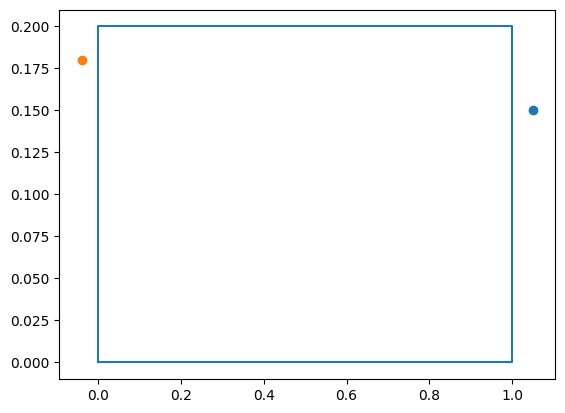

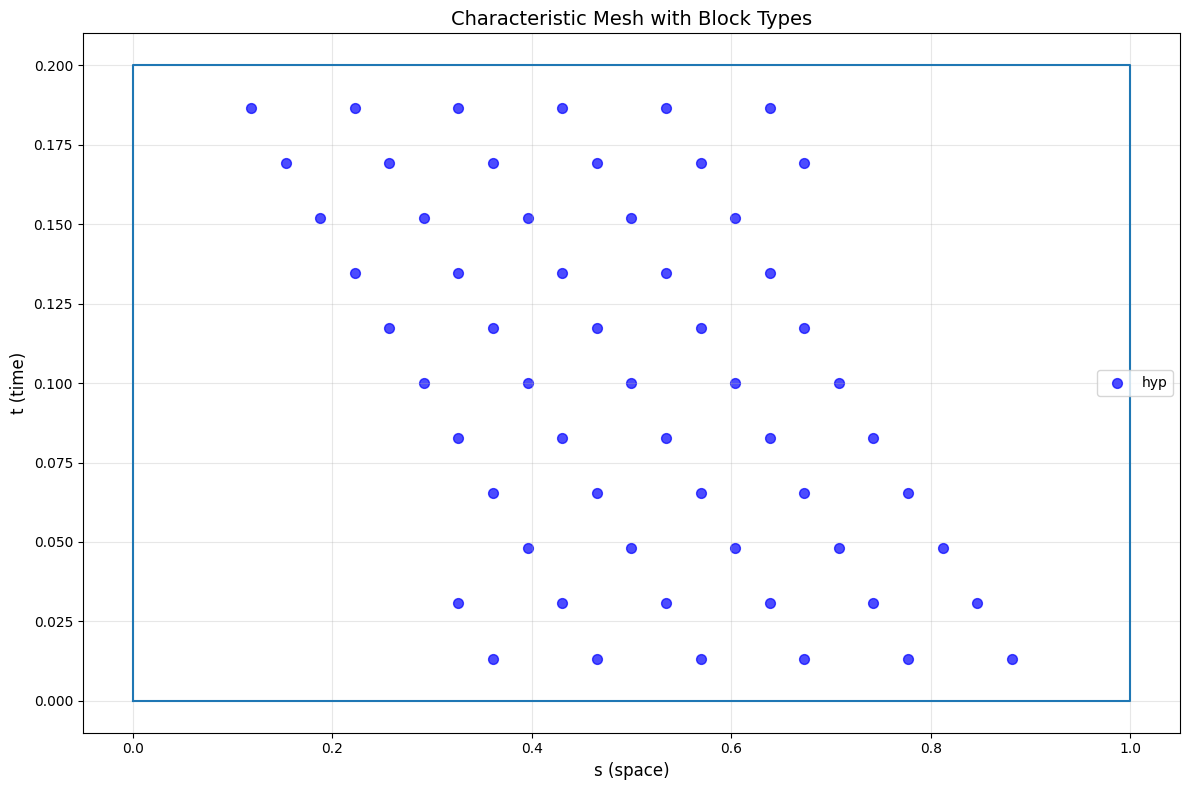

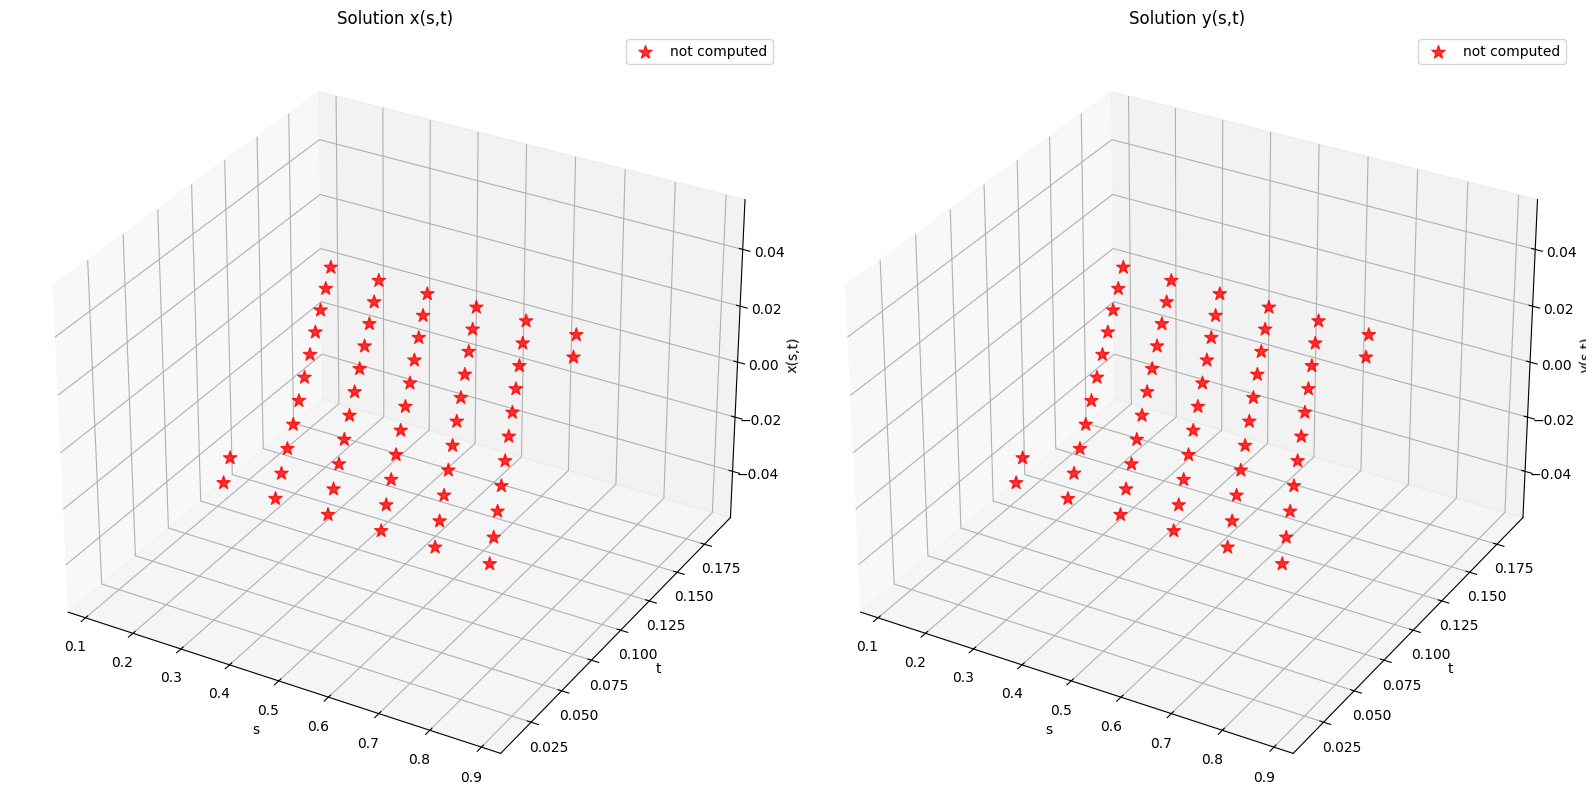

In [371]:
"""
Основной скрипт для запуска тестового кейса
"""
import numpy as np

def run_test_case():
    # Параметры задачи
    S = [0, 1]
    T = [0, 0.2]
    C = [1, 2]  # c1 для x, c2 для y
    h = 0.052
    
    # Аналитические решения
    x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
    y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
    

    # Создаем ProblemManager
    manager = ProblemManager(S, T)
    # Визуализация
    ploter = Ploter(manager)
    
    # Создаем HypBlock (теперь параметры передаются явно)
    hyp_block = manager.create_hyp_block('hyp_block', C[0], C[1])
    ploter.plot_frame(hyp_block.frame)
    hyp_block.build(h)  # <-- ИЗМЕНЕНИЕ: вызов build вместо build_grid_by_time_step
    
    # Создаем FunBlock для начальных условий (t=0)
    fun_bottom = manager.create_fun_block(
        'fun_bottom', 
        lambda s, t: x_an(s, T[0]),
        lambda s, t: y_an(s, T[0]),
        'initial',
        'bottom'
    )
    
    # Создаем FunBlock для левой границы (s=0) - задаем y
    fun_left = manager.create_fun_block(
        'fun_left',
        lambda s, t: None,  # x вычисляется из решения
        lambda s, t: y_an(S[0], t),  # y задано на левой границе
        'boundary',
        'left'
    )
    
    # Создаем FunBlock для правой границы (s=1) - задаем x
    fun_right = manager.create_fun_block(
        'fun_right',
        lambda s, t: x_an(S[1], t),  # x задано на правой границе
        lambda s, t: None,  # y вычисляется из решения
        'boundary',
        'right'
    )
    
    # Строим объединенную сетку
    manager.build_mesh()
    
    # Создаем Solver и определяем порядок вычислений
    solver = Solver(manager)
    order = solver.determine_order()
    
    # Выводим информацию
    print(f"Total nodes: {len(manager.mesh)}")
    print(f"HypBlock nodes: {len(hyp_block.nodes)}")
    print(f"FunBlock bottom nodes: {len(fun_bottom.nodes)}")
    print(f"FunBlock left nodes: {len(fun_left.nodes)}")
    print(f"FunBlock right nodes: {len(fun_right.nodes)}")
    print(f"Solution order length: {len(order)}")
    
    
    ploter.plot_mesh()
    ploter.plot_frame(hyp_block.frame)
    ploter.plot_3d_solution()
    
    return manager, solver, ploter

if __name__ == "__main__":
    manager, solver, ploter = run_test_case()

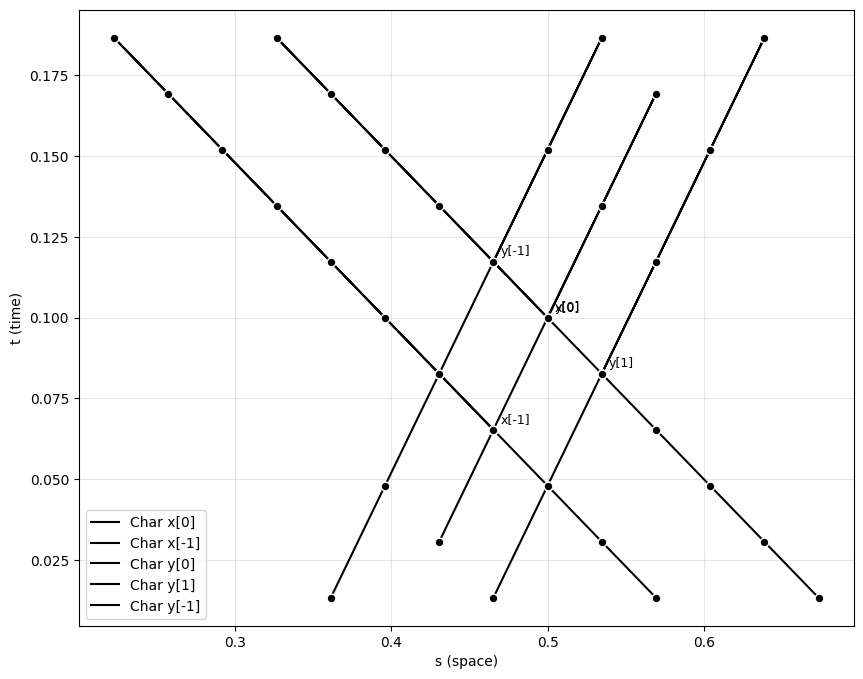

In [353]:
ax = ploter.plot_characteristic( manager.blocks['hyp_block'].x_chars[0])
# ax = ploter.plot_characteristic( manager.blocks['hyp_block'].x_chars[1], ax)
ax = ploter.plot_characteristic( manager.blocks['hyp_block'].x_chars[-1], ax)

ax = ploter.plot_characteristic( manager.blocks['hyp_block'].y_chars[0], ax)
ax = ploter.plot_characteristic( manager.blocks['hyp_block'].y_chars[1], ax)
ax = ploter.plot_characteristic( manager.blocks['hyp_block'].y_chars[-1], ax)

In [295]:
manager.blocks['hyp_block'].y_chars

{-3: <__main__.Characteristic at 0x704ceffacc20>,
 -2: <__main__.Characteristic at 0x704ceffadb20>,
 -1: <__main__.Characteristic at 0x704ceffac560>,
 0: <__main__.Characteristic at 0x704cefd64620>,
 1: <__main__.Characteristic at 0x704cefd64890>,
 2: <__main__.Characteristic at 0x704cefd65ee0>,
 3: <__main__.Characteristic at 0x704cefd65310>}

In [296]:
manager.blocks['hyp_block'].x_chars

{-3: <__main__.Characteristic at 0x704cf5097cb0>,
 -2: <__main__.Characteristic at 0x704cefd9c5f0>,
 -1: <__main__.Characteristic at 0x704cf844e150>,
 0: <__main__.Characteristic at 0x704cf5cf53d0>,
 1: <__main__.Characteristic at 0x704cefe46db0>,
 2: <__main__.Characteristic at 0x704cefa4ac90>,
 3: <__main__.Characteristic at 0x704ceffacfe0>}